In [1]:
from dpks.quant_matrix import QuantMatrix
from sklearn.cluster import KMeans, AgglomerativeClustering, FeatureAgglomeration, HDBSCAN

import pandas as pd
import numpy as np
import seaborn as sns

In [2]:
design_matrix = pd.read_csv(
    "../tests/input_files/design_sepsis.tsv",
    #"/home/aaron/projects/dpks/notebooks/ml_api/covid_design_matrix.tsv",
    sep="\t"
)

In [3]:
design_matrix = design_matrix.sort_values("group", ascending=False).reset_index(drop=True)
design_matrix

,sample,group
0,TM_P1911_190,2
1,TM_P1912_030,2
2,TM_P1912_032,2
3,TM_P1912_033,2
4,TM_P1912_034,2
...,...,...
192,TM_M2012_138,1
193,TM_M2012_046,1
194,TM_M2012_129,1
195,TM_M2012_128,1


In [4]:
design_matrix['group'].value_counts()

group
2    123
1     74
Name: count, dtype: int64

In [5]:
qm = (
    
    QuantMatrix(
        quantification_file="../tests/input_files/data_sepsis.tsv",
        design_matrix_file=design_matrix
    )
    .filter()
    .normalize(method="mean", use_rt_sliding_window_filter=True, rt_unit="second", stride=5, minimum_data_points=200)
    .quantify(method="top_n", top_n=5, summarization_method="mean").impute(method="neighborhood")
    .annotate()
).to_df()

# IGKV3-20
# IGHV3-30
# IGKV1-39
# IGKV1-17
# IGLV3-25

qm = qm[~qm['Gene'].str.contains("IGKV")]
qm = qm[~qm['Gene'].str.contains("IGHV")]
qm = qm[~qm['Gene'].str.contains("IGLV")]

/home/aaron/projects/dpks/DPKS/dpks/quantification.py:94: RuntimeWarning: Mean of empty slice
  quantification: np.ndarray = np.nanmean(


In [6]:
qm = (
    
    QuantMatrix(
        quantification_file=qm,
        design_matrix_file=design_matrix
    )
    .compare(method="linregress", min_samples_per_group=10, comparisons=[(2, 1)])
    .cluster()
)

<Axes: xlabel='distance', ylabel='Count'>

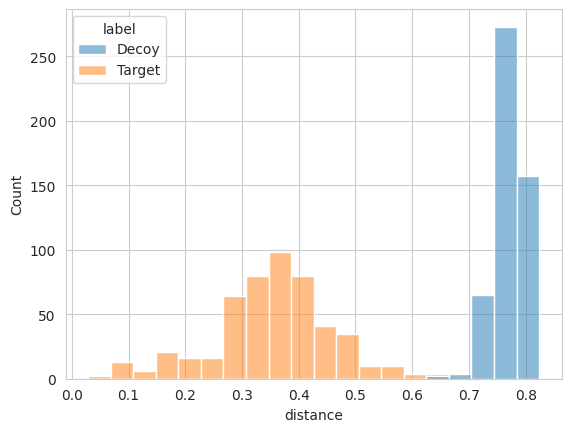

In [7]:
sns.histplot(qm.clusterer.distance_df, x="distance", hue="label", bins=20)

In [8]:
qm.row_annotations.sort_values("FeatureCluster")

,Protein,Gene,DEScore2-1,Group2Mean,Group1Mean,Group2Stdev,Group1Stdev,Log2FoldChange2-1,PValue2-1,Group2RepCounts,Group1RepCounts,CorrectedPValue2-1,-Log10CorrectedPValue2-1,FeatureCluster
50,P12259,F5,0.435766,20.303868,19.823563,0.542135,0.654648,0.480305,9.995655e-08,123,74,3.998262e-07,6.398129,1
113,P18065,IGFBP2,0.704018,19.845700,18.745288,1.320140,1.530256,1.100412,3.042366e-07,123,74,1.077867e-06,5.967435,1
60,P02774,GC,0.291298,26.652805,26.326852,0.490557,0.537000,0.325953,2.334411e-05,123,74,5.620718e-05,4.250208,1
307,P36980,CFHR2,0.366971,22.244005,21.746672,0.595742,0.973533,0.497332,1.600098e-05,123,74,3.962111e-05,4.402073,1
464,P11216,PYGB,0.223890,24.622760,24.950088,0.851425,0.477593,-0.327328,2.892363e-03,123,74,3.835861e-03,2.416137,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
315,P04040,CAT,0.086151,18.399099,18.251265,1.253173,1.499924,0.147834,4.602357e-01,123,74,2.666786e-01,0.574012,138
151,Q16851,UGP2,0.079334,17.930204,18.067028,1.169303,1.972892,-0.136824,5.438670e-01,123,74,3.058481e-01,0.514494,138
459,P00480,OTC,0.044667,18.916850,18.840229,1.155951,1.268628,0.076621,6.662366e-01,123,74,3.574955e-01,0.446729,139
98,Q93088,BHMT,0.158381,20.660885,20.389028,1.561870,1.581543,0.271857,2.428104e-01,123,74,1.584657e-01,0.800065,139


In [10]:
from scipy.cluster import hierarchy
from scipy.spatial.distance import squareform

dist_linkage = hierarchy.linkage(
    squareform(qm.clusterer.target_distance_matrix), 
    method="ward"
)

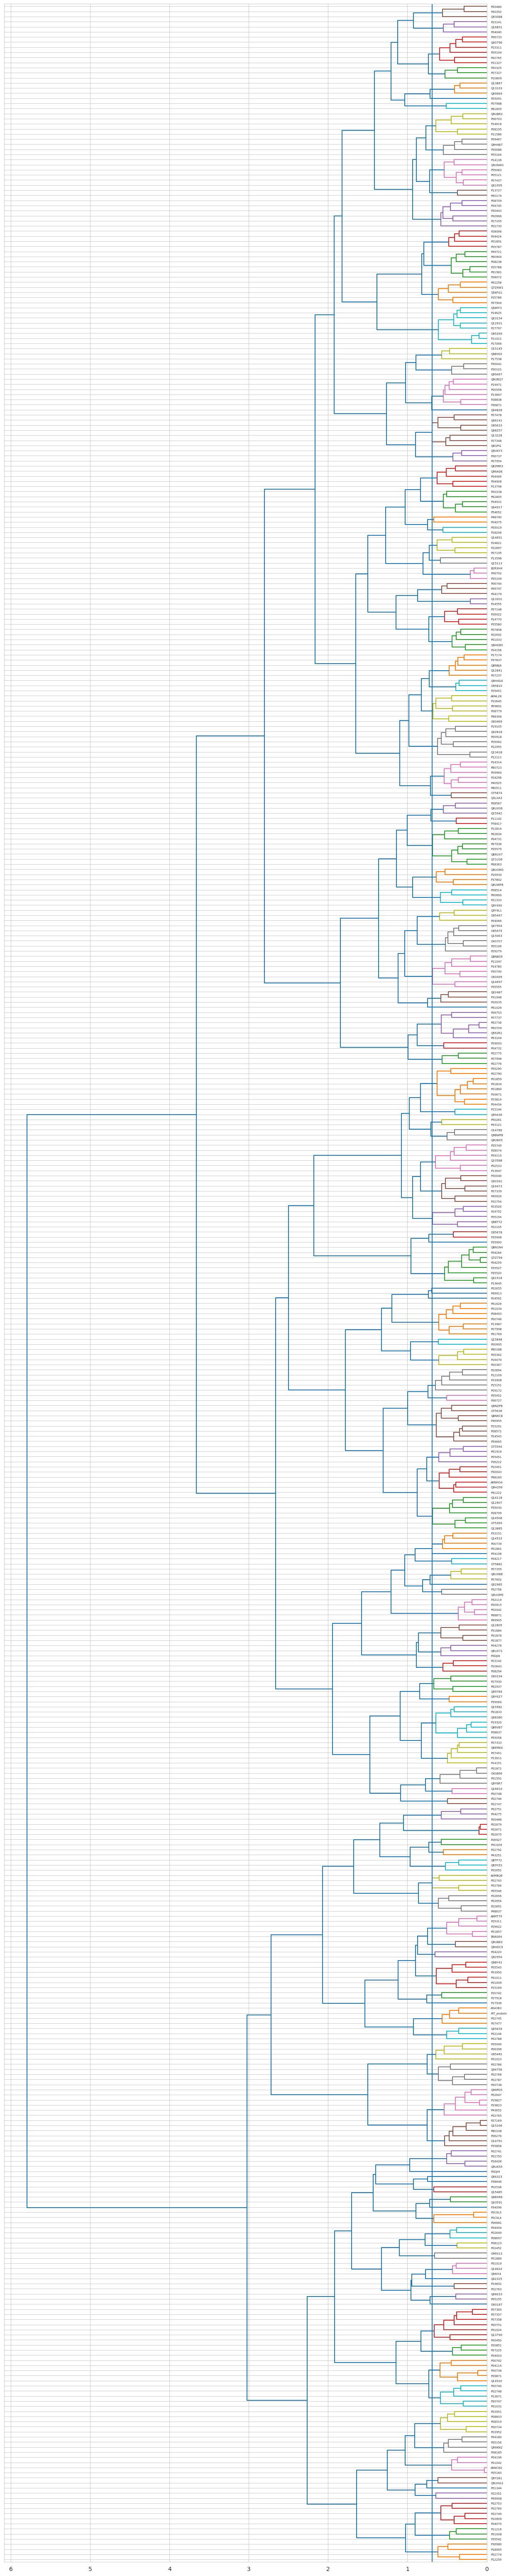

In [11]:
import matplotlib.pyplot as plt

plt.figure()

dn = hierarchy.dendrogram(dist_linkage, 
                          orientation="left", 
                          color_threshold=qm.clusterer.distance_cutoff,
                          labels=qm.row_annotations['Protein'])

plt.gca().axvline(x=qm.clusterer.distance_cutoff)

plt.gcf().set_size_inches(15, 80)

In [12]:
feature_clusters_df = qm.to_df()

In [13]:
filtered_df = feature_clusters_df.loc[
    feature_clusters_df.groupby("FeatureCluster")['CorrectedPValue2-1'].idxmin()
].copy()

In [14]:
qm_filtered = (
    
    QuantMatrix(
        quantification_file=filtered_df,
        design_matrix_file=design_matrix
    )
    
)

In [15]:
import xgboost

clf = xgboost.XGBClassifier(
    max_depth=2,
    #subsample=0.5,
    reg_lambda=2,
    objective="binary:logistic",
    seed=42
)

#
qm_filtered = qm_filtered.explain(
    clf,
    comparisons=[(2, 1)],
    n_iterations=10,
    downsample_background=True
)

In [26]:
qm_filtered.row_annotations.sort_values("MeanImportance2-1", ascending=False).head(10)

,Protein,Gene,DEScore2-1,Group2Mean,Group1Mean,Group2Stdev,Group1Stdev,Log2FoldChange2-1,PValue2-1,Group2RepCounts,Group1RepCounts,CorrectedPValue2-1,-Log10CorrectedPValue2-1,FeatureCluster,MeanImportance2-1,MeanRank2-1
69,P06727,APOA4,0.823301,25.442027,24.360986,0.911909,1.122310,1.081041,5.675327e-12,123,74,5.212893e-11,10.282921,70,0.885951,1.70
68,P59665,DEFA1,1.298690,22.938065,21.490092,0.951574,0.842042,1.447973,1.988787e-21,123,74,4.932191e-19,18.306960,69,0.522379,2.70
71,P05362,ICAM1,1.357118,19.934267,18.281489,1.240808,0.655209,1.652779,7.118802e-21,123,74,5.884876e-19,18.230263,72,0.482133,2.90
30,Q96PD5,PGLYRP2,0.744918,21.714376,22.507637,0.708453,0.671858,-0.793261,5.933360e-13,123,74,6.131139e-12,11.212459,31,0.310572,13.60
73,P61769,B2M,1.076449,22.823686,21.643795,0.733103,0.974937,1.179891,4.413086e-18,123,74,1.368057e-16,15.863896,74,0.256446,6.00
29,P35858,IGFALS,0.491625,20.317330,21.028709,1.109570,0.717600,-0.711379,1.968163e-06,123,74,6.306952e-06,5.200180,30,0.202373,7.80
70,P12109,COL6A1,0.916792,18.838322,17.917189,0.720126,0.655965,0.921133,2.964058e-16,123,74,6.125720e-15,14.212843,71,0.117974,21.55
52,P19320,VCAM1,1.083607,19.122258,18.155677,0.588427,0.711141,0.966581,5.133936e-20,123,74,2.546432e-18,17.594068,53,0.116702,16.45
27,P18428,LBP,0.500513,23.456669,22.751223,0.966166,0.874544,0.705445,7.497413e-07,123,74,2.512646e-06,5.599869,28,0.102681,11.70
31,Q04756,HGFAC,0.392701,19.254499,19.749946,0.687477,0.691365,-0.495446,2.371981e-06,123,74,7.353142e-06,5.133527,32,0.084516,12.60


<Axes: xlabel='MeanImportance2-1', ylabel='Gene'>

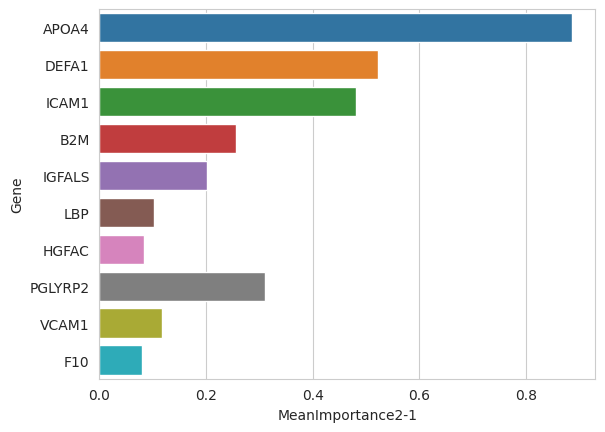

In [27]:
sns.barplot(
    data=qm_filtered.row_annotations.sort_values("MeanRank2-1", ascending=True).head(10),
    x="MeanImportance2-1",
    y="Gene"
)

In [28]:
selected_clusters = qm_filtered.row_annotations.sort_values("MeanRank2-1", ascending=True).head(10)['FeatureCluster'].values

In [29]:
qm.row_annotations[qm.row_annotations['FeatureCluster'].isin(selected_clusters)]

,Protein,Gene,DEScore2-1,Group2Mean,Group1Mean,Group2Stdev,Group1Stdev,Log2FoldChange2-1,PValue2-1,Group2RepCounts,Group1RepCounts,CorrectedPValue2-1,-Log10CorrectedPValue2-1,FeatureCluster
8,P02787,TF,0.114378,29.080894,29.235061,0.498493,0.448078,-0.154166,3.112043e-02,123,74,2.921154e-02,1.534445,32
9,P00738,HP,0.069402,30.383598,30.264077,1.583586,1.104578,0.119521,5.705962e-01,123,74,3.172822e-01,0.498554,32
16,P01833,PIGR,0.683225,21.296659,20.228673,1.555793,1.044303,1.067986,4.758315e-07,123,74,1.638975e-06,5.785428,53
19,P19823,ITIH2,0.647102,24.466525,25.121607,0.686775,0.470310,-0.655082,1.204775e-11,123,74,1.030290e-10,9.987040,31
20,P02647,APOA1,0.496280,28.098708,28.711876,0.802006,0.601049,-0.613169,5.428636e-08,123,74,2.361933e-07,6.626732,31
24,P01034,CST3,0.596771,20.999049,20.294765,0.625732,0.889936,0.704285,7.744293e-10,123,74,4.466476e-09,8.350035,74
31,P02750,LRG1,0.294239,25.726686,25.326911,0.711183,0.676590,0.399775,1.477257e-04,123,74,3.052998e-04,3.515273,28
35,P61626,LYZ,0.768608,21.052191,20.225375,0.666539,0.784903,0.826816,2.890111e-13,123,74,3.257943e-12,11.487056,74
39,Q04756,HGFAC,0.392701,19.254499,19.749946,0.687477,0.691365,-0.495446,2.371981e-06,123,74,7.353142e-06,5.133527,32
40,P02768,ALB,0.024260,32.911592,32.883534,0.230820,0.241586,0.028058,4.202495e-01,123,74,2.493346e-01,0.603217,32


In [30]:
for gene in qm.row_annotations[qm.row_annotations['FeatureCluster'].isin(selected_clusters)]['Gene']:
    
    print(gene)

TF
HP
PIGR
ITIH2
APOA1
CST3
LRG1
LYZ
HGFAC
ALB
APOA4
APOB
AFM
C1S
LGALS3BP
ITIH1
ICAM1
F10
TGFBI
AHSG
SERPINF1
NID1
FCN3
CD163
CD14
HABP2
CD44
APOL1
RNASE1
B2M
C1R
C1RL
B4GALT1
VCAM1
CLEC3B
DEFA1
CD59
PLTP
SERPINA10
BCHE
TFRC
MGP
GPLD1
PGLYRP2
GLUD1
CRP
LILRA3
PON3
IGFALS
PON1
LCN2
CFD
LBP
FCGR3A


In [31]:
qm.sample_annotations['group'].unique()

array([2, 1])

In [34]:
qm.row_annotations.shape

(501, 14)

In [39]:
filtered_df = qm_filtered.to_df()

In [41]:
small_qm = QuantMatrix(
    quantification_file=filtered_df[filtered_df['Gene'].isin(qm.row_annotations[qm.row_annotations['FeatureCluster'].isin(selected_clusters)]['Gene'])],
    design_matrix_file=design_matrix
)

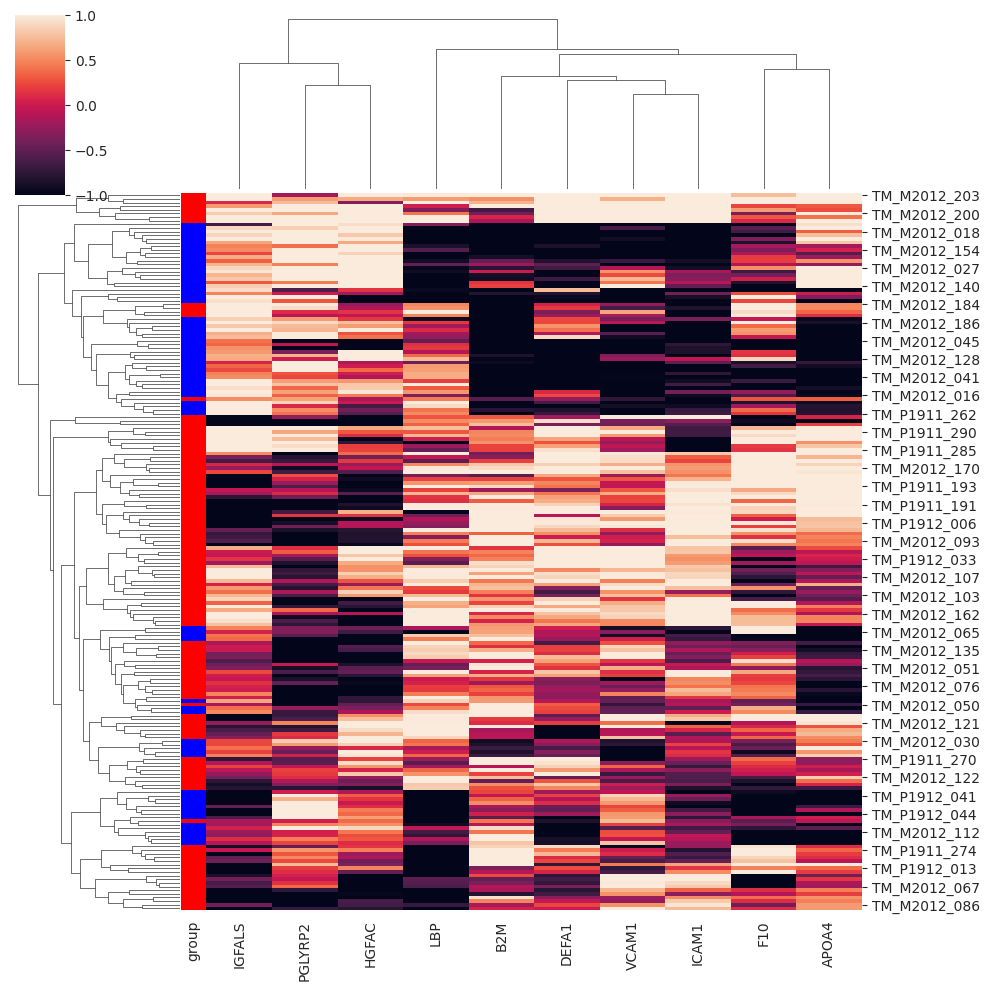

In [42]:
lut = dict(zip(small_qm.sample_annotations['group'].unique(), "rbg"))
row_colors = small_qm.sample_annotations['group'].map(lut)
sns.clustermap(
    small_qm.to_ml(feature_column="Gene")[0], 
    row_colors=row_colors,
    z_score=1,
    vmin=-1,
    vmax=1,
)

In [36]:
qm_filtered.row_annotations.shape

(139, 16)

/home/aaron/miniconda3/envs/DPKS/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/home/aaron/miniconda3/envs/DPKS/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


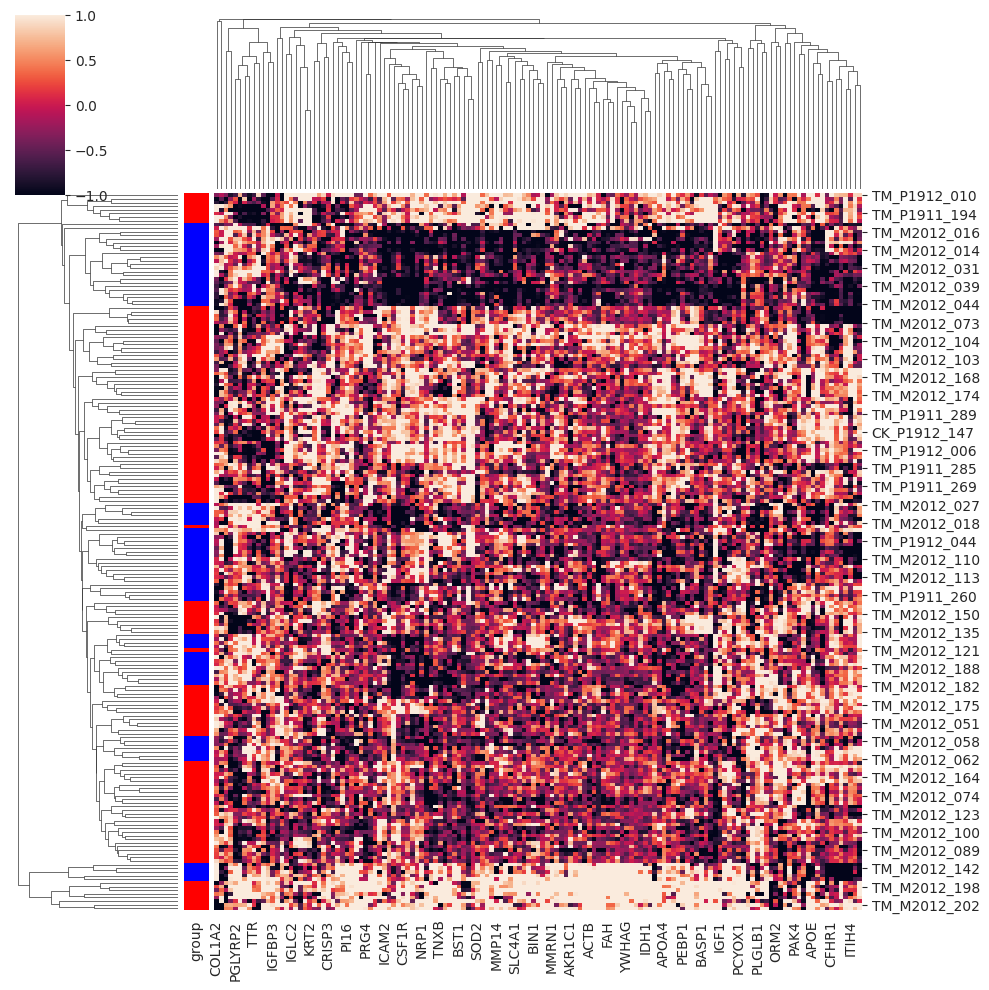

In [33]:
lut = dict(zip(qm_filtered.sample_annotations['group'].unique(), "rbg"))
row_colors = qm_filtered.sample_annotations['group'].map(lut)
sns.clustermap(
    qm_filtered.to_ml(feature_column="Gene")[0], 
    row_colors=row_colors,
    z_score=1,
    vmin=-1,
    vmax=1,
)